# BE Hawkes

## Importation des librairies

In [14]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()

from ipywidgets import interact, widgets

from numba import njit, prange
import time

## Algorithmes de simulation

In [15]:
def Simulate_HPP(lamb, T):
    n = 0
    t = [- np.log(npr.random()) / lamb]
    while t[-1] <= T:
        u = npr.random()
        w = - np.log(u) / lamb
        t.append(t[-1] + w)
    return t[:-1]

In [16]:
def Simulate_IPP(lamb, T, lamb_bar):
    n = 0
    m = 0
    t = []
    s = 0
    
    while s < T:
        u = npr.random()
        w = -np.log(u)/lamb_bar
        s += w
        D = npr.random()
        if D < lamb(s)/lamb_bar:
            t.append(s)
    if t[-1] < T:
        return t
    else:
        return t[:-1]

In [17]:
@njit
def lambda_bar(mu, alpha, beta, s, tau):
    S = mu
    for t in tau:
        S += alpha * np.exp(- beta * (s - t))
    return S

@njit
def Simulate_Hawkes(mu, alpha, beta, T):    
    tau = [0.0]  # Necessary to Numba
    s = 0
    while s < T:
        u = npr.random()
        lamb_bar = lambda_bar(mu, alpha, beta, s, tau[1:])  # On prend pas le premier 0.0
        w = -np.log(u) / lamb_bar
        s += w
        D = npr.random()
        
        if D * lamb_bar < lambda_bar(mu, alpha, beta, s, tau[1:]):  # On prend pas le premier 0.0
            tau.append(s)
        
    # We take off the first 0 in both cases
    if tau[-1] < T:
        return tau[1:]
    else:
        return tau[1:-1]
    
def lamb_Hawkes(t, tau, mu, alpha, beta):
    tau_inf = np.asarray(tau)[np.where(np.asarray(tau) < t)]
    return mu + sum([alpha * np.exp(- beta * (t - Tau)) for Tau in tau_inf])

## Fonctions d'affichage

In [18]:
def plot_PP(t):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.step([0] + t, [0] + list(range(len(t))))
    plt.scatter(t,[0] * len(t), color='r')
    for h, T in enumerate(t):
        plt.plot([T, T], [0, h], '--', color="darkred")
    ax.set_xlabel("t", fontsize=20)
    ax.set_ylabel("N(t)", fontsize=20)
    plt.show()

In [19]:
def plot_Hawkes(mu, alpha, beta, T):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
    tau = Simulate_Hawkes(mu, alpha, beta, T)
    ax[0].step([0] + tau, [0] + list(range(len(tau))))
    ax[0].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[0].plot([Tau, Tau], [0, h], '--', color="darkred")
    
    tt = np.linspace(0, T, num=10000)
    lamb_to_plot = [lamb_Hawkes(t, tau, mu, alpha, beta) for t in tt]
    
    ax[1].plot(tt, lamb_to_plot)
    ax[1].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[1].plot([Tau, Tau], [0, lamb_Hawkes(Tau, tau, mu, alpha, beta)], '--', color="darkred")
    
    
    ax[1].set_xlabel("t",fontsize=20)
    ax[0].set_ylabel("N(t)",fontsize=20)
    ax[1].set_ylabel("$\lambda$(t)",fontsize=20)
    
    ax[0].set_title("Processus de Hawkes, " + r"$\mu =$"  + str(mu) +  r"$, \alpha =$" + str(alpha) + r"$, \beta =$" + str(beta), fontsize=20)
    plt.show()

## Visualisation

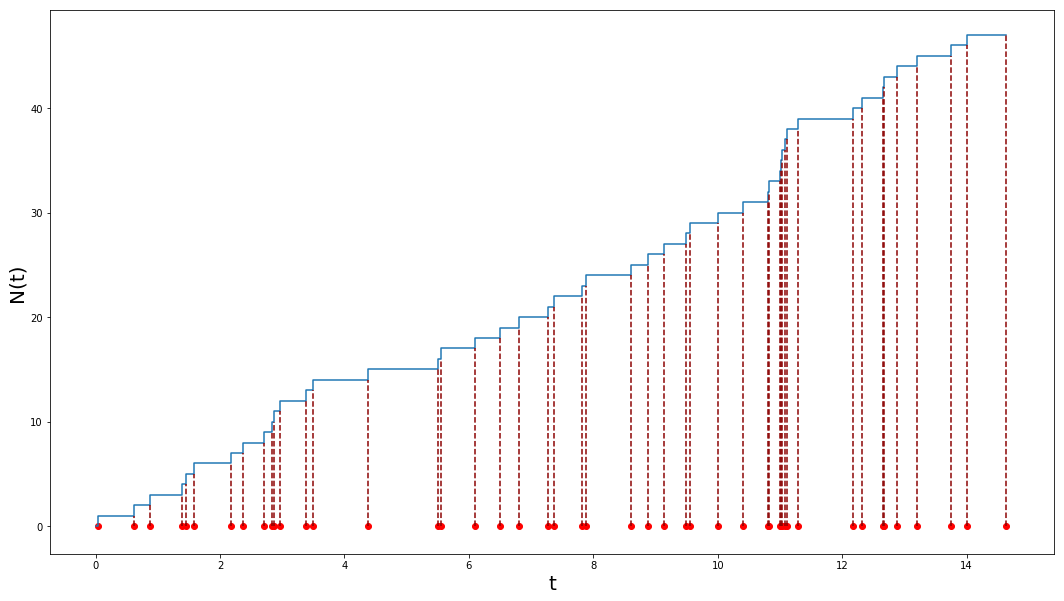

In [20]:
#HPP
plot_PP(Simulate_HPP(3, 15))

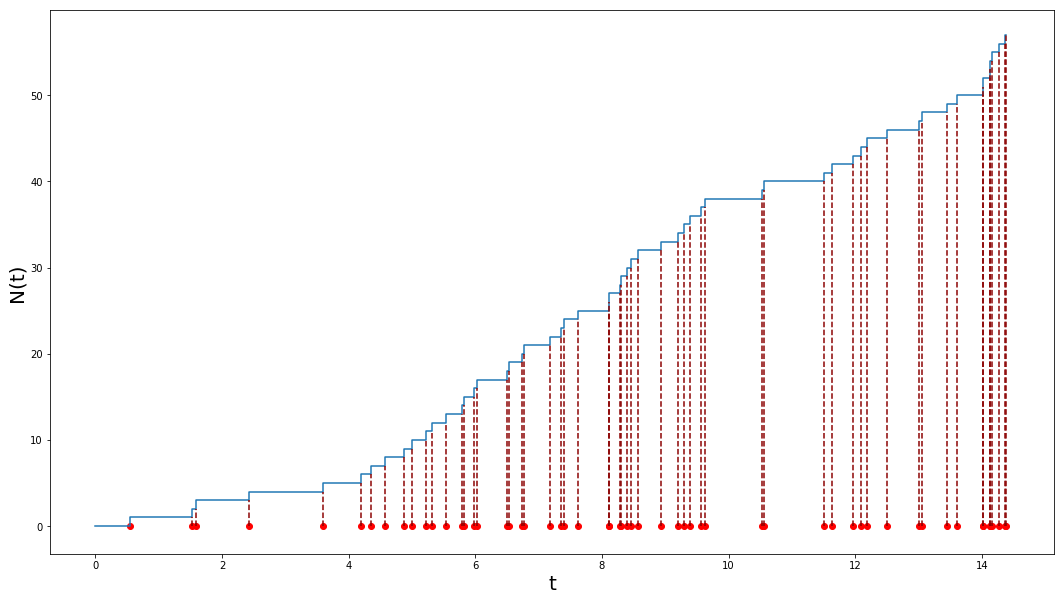

In [21]:
#IPP
def lamb0(t):
    return t
plot_PP(Simulate_IPP(lamb0, 15, 15))

In [22]:
mu = 1.2
alpha = 0.6
beta = 0.8
T = 15

@interact(alpha=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.6, continuous_update=False),
          beta=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.8, continuous_update=False))
def test_param(alpha, beta):
    if alpha < beta:
        plot_Hawkes(mu, alpha, beta, T)
    else:
        print("Alpha must be lower than beta !")

interactive(children=(FloatSlider(value=0.6, continuous_update=False, description='alpha', max=3.0), FloatSlid…

Avec $\alpha = 0$, on retrouve un PP homogène.

Plus $\alpha$ est grand, plus le processus saute souvent et plus il s'auto-excite.

Plus $\beta$ est grand, plus la décroissance de $\lambda$ est rapide

## Cramer-Lundberg model with Hawkes process

In [30]:
@njit
def X_Hawkes(mu, sigma, alpha, beta, T):
    '''Computation of claims utile time T '''
    N = len(Simulate_Hawkes(mu, alpha, beta, T))
    X = np.exp(npr.normal(mu, sigma, N)) #logNormale
    return X

@njit(parallel=True)
def Rapport_ST(mu, sigma, alpha, beta, T, N, nb_alpha, nb_beta):
    """Computation of the ratio of the expection of S_T from Hawkes processes estimated by Monte-Carlo 
    and the expection of S_T from HPP with parameter mu"""
    range_beta = np.linspace(alpha, 3, nb_beta)
    range_alpha = np.linspace(0, beta, nb_alpha)
    S_beta = np.zeros(nb_beta)
    S_alpha = np.zeros(nb_alpha)
    for i in prange(N):
        S_beta += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for beta in range_beta])
        S_alpha += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for alpha in range_alpha])
    S_beta = S_beta / (T * mu * np.exp(mu + sigma ** 2 / 2)) / N
    S_alpha = S_alpha / (T * mu * np.exp(mu + sigma ** 2 / 2)) / N
    
    return range_alpha, S_alpha, range_beta, S_beta
    
def plot_rapports(range_alpha, S_alpha, range_beta, S_beta):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 15))
    
    ax[0].plot(range_beta, S_beta)
    ax[0].set_title("Relate to " + r"$\alpha = $" + str(alpha), fontsize=20)
    ax[0].set_xlabel(r"$\beta$", fontsize=20)
    ax[0].set_ylabel(r"$E[S_T^H]/E[S_T^N]$", fontsize=20)

    ax[1].plot(range_alpha, S_alpha)
    ax[1].set_title("Reltate to " + r"$\beta = $" + str(beta), fontsize=20)
    ax[1].set_xlabel(r"$\alpha$", fontsize=20)
    ax[1].set_ylabel(r"$E[S_T^H]/E[S_T^N]$", fontsize=20)
    
    plt.show()

In [31]:
mu = 1.2
sigma = 2
T = 10
alpha = 1
beta = 1
N = 15000
nb_alpha = 100
nb_beta = 100

range_alpha, S_alpha, range_beta, S_beta = Rapport_ST(mu, sigma, alpha, beta, T, N, nb_alpha, nb_beta)
plot_rapports(range_alpha, S_alpha, range_beta, S_beta)

RecursionError: Failed at nopython (convert to parfors)
maximum recursion depth exceeded in comparison

On peut aussi le visualiser sous la forme de matrice pour prendre en compte les variations de alpha et beta en même temps.

In [12]:
@njit(parallel=True)
def mat_rapport_esp(mu, sigma, alpha_max, beta_max, T, N, nb_alpha, nb_beta):
    """Calcul du rapport entre l'espérance de S_T avec le processus de Hawkes estimée par Monte-Carlo 
    et l'espérance de S_T du processus de Poisson homogène de paramètre mu"""
    
    range_alpha = np.linspace(0, alpha_max, nb_alpha)    
    range_beta = np.linspace(alpha_max, beta_max, nb_beta)
    result = np.zeros((nb_alpha, nb_beta))
    
    for i in prange(N):
        for ind, beta in enumerate(range_beta):
            result[:, ind] += np.array([np.sum(X_Hawkes(mu, sigma, alpha, beta, T)) for alpha in range_alpha[::-1]])
    
    result = result / N # Moyenne sur N réalisations
    result = result / (T * mu * np.exp(mu + sigma ** 2 / 2))  # Rapport des espérances
    
    return result, range_alpha, range_beta

def plot_mat_rapport(result, range_alpha, range_beta):
    fig, ax = plt.subplots(figsize=(13, 8))
    sns.heatmap(result, annot=True, cbar=True, xticklabels=np.round(range_beta, 2), yticklabels=np.round(range_alpha[::-1], 2))
    ax.set_xlabel("Values of beta")
    ax.set_ylabel("Values of alpha")
    plt.show()

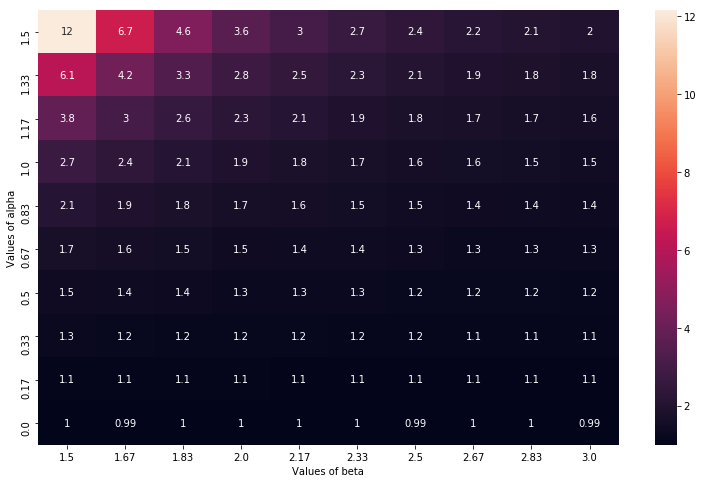

In [13]:
mu = 1.2
sigma = 1
T = 15
N = 10000
nb_alpha = 10
nb_beta = 10
alpha_max = 1.5
beta_max = 3

plot_mat_rapport(*mat_rapport_esp(mu, sigma, alpha_max, beta_max, T, N, nb_alpha, nb_beta))

On souhaite maintenant prendre en compte l'importance du sinistre. Au delà d'un certain seuil on considérera que les répercutions du sinistre sont plus importantes. Par exemple, plus un accident est important, plus le nombre de soins médicaux qu'il engendre le seront également. 

Nous allons donc modéliser  $\lambda$ par $\mu + \sum_{{k :t_k < t}}\alpha \exp({-\beta (t-t_k)}) \mathbb{1}_{X_k > S} $
avec $X_k$ la valeur du sinistre et $S$ le seuil. 

## Hawkes seuillé

In [14]:
@njit
def lambda_bar_Seuil(mu, alpha, beta, s, tau, X, Seuil):
    S = mu
    for ind, t in enumerate(tau[1:]):  # On touche pas au premier 0.0
        S += alpha * np.exp(- beta * (s - t)) * (X[ind + 1] >= Seuil)
    return S

@njit
def Simulate_Hawkes_Seuil(mu, sigma, alpha, beta, T, S):
    tau = [0.0]
    s = 0
    X = [0.0]
    while s < T:
        X += list(np.exp(npr.normal(mu, sigma, 1))) #Loi logNormale
        lamb_bar = lambda_bar_Seuil(mu, alpha, beta, s, tau, X, S)
        u = npr.random()
        w = -np.log(u)/lamb_bar
        s += w
        D = npr.random()
        
        if D * lamb_bar < lambda_bar_Seuil(mu, alpha, beta, s, tau, X, S):
            tau += [s]
        else:
            del X[-1]
        
        
    if tau[-1] < T:
        return tau[1:], np.array(X[1:])
    else:
        return tau[1:-1], np.array(X[1:-1])

def lamb_Hawkes_Seuil(t, tau, mu, alpha, beta, X, S):
    tau_inf = np.asarray(tau)[np.where(np.asarray(tau) < t)]
    return mu + sum([alpha * np.exp(- beta * (t - Tau)) * (X[ind] > S) for ind, Tau in enumerate(tau_inf)])

Evaluation du seuil : 

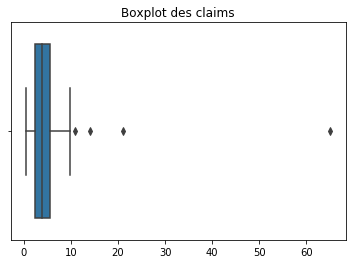

In [25]:
mu = 1.2
sigma = 1
alpha = 0.6
beta = 0.8
T = 15
X = X_Hawkes(mu, sigma, alpha, beta, T)
sns.boxplot(X)
plt.title("Boxplot des claims")
plt.show()

In [16]:
S = np.quantile(X, 0.75)
print("3ème quartile : ", np.quantile(X, 0.75))
print("Claims max : ", max(X))

3ème quartile :  8.230441817432617
Claims max :  22.03391237472907


In [27]:
def plot_Hawkes_Seuil(mu, sigma, alpha, beta, T, S):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
    tau, X = Simulate_Hawkes_Seuil(mu, sigma, alpha, beta, T, S)
    ax[0].step([0] + tau, [0] + list(range(len(tau))))
    ax[0].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[0].plot([Tau, Tau], [0, h], '--', color="darkred")
    
    tt = np.linspace(0, T, num=10000)
    lamb_to_plot = [lamb_Hawkes_Seuil(t, tau, mu, alpha, beta, X, S) for t in tt]
    
    ax[1].plot(tt, lamb_to_plot)
    ax[1].scatter(tau, [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[1].plot([Tau, Tau], [0, lamb_Hawkes_Seuil(Tau, tau, mu, alpha, beta, X, S)], '--', color="darkred")
    
    
    ax[1].set_xlabel("t", fontsize=20)
    ax[0].set_ylabel("N(t)", fontsize=20)
    ax[1].set_ylabel("$\lambda$(t)", fontsize=20)
    
    ax[0].set_title("Processus de Hawkes avec Seuil = " + str(S) + ", " + r"$\mu =$"  + str(mu) +  r"$, \alpha =$" + str(alpha) + r"$, \beta =$" + str(beta), fontsize=20)
    plt.show()

NameError: name 'Simulate_Hawkes_Seuil' is not defined

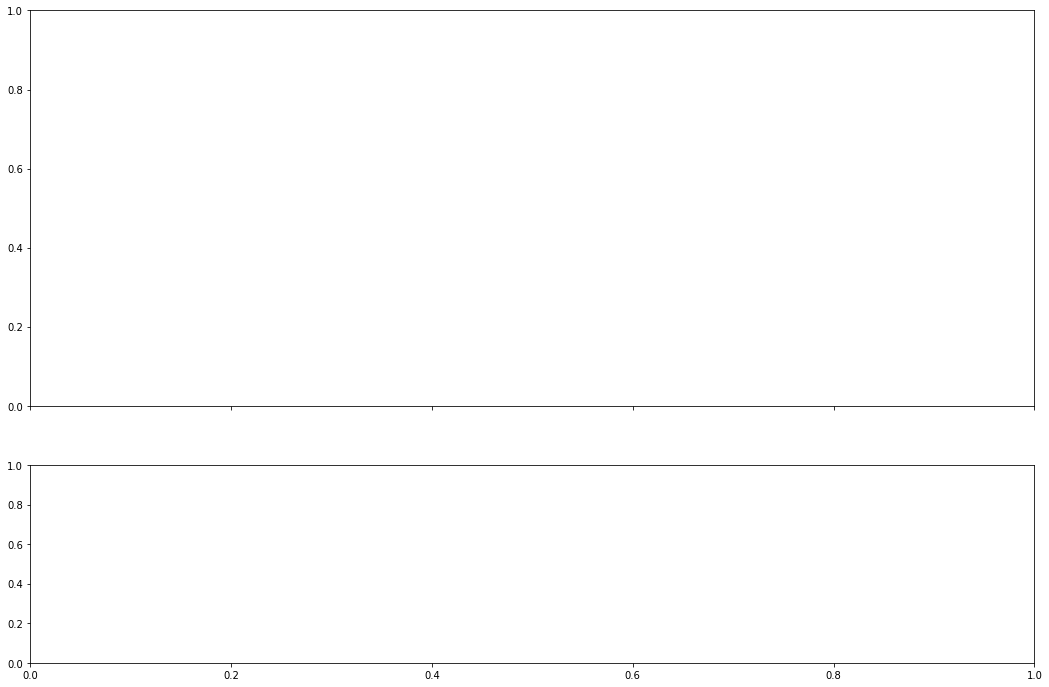

In [28]:
mu = 1.2
sigma = 1
alpha = 0.6
beta = 0.8
S = 6
plot_Hawkes_Seuil(mu, sigma, alpha, beta, T, 0)

In [24]:
@njit(parallel=True)
def Rapport_ST_Hawkes_Seuil(mu, sigma, alpha, beta, T, N, nb_seuil, Seuil_max):
    """Calcul du rapport entre l'espérance de S_T avec le processus de Hawkes seuillé et estimée 
    par Monte-Carlo et l'espérance de S_T du processus de Hawkes estimée par Monte-Carlo """
    
    range_seuil = np.linspace(0, Seuil_max, nb_seuil)    
    S_Hawkes = np.zeros(nb_seuil)
    S_Hawkes_seuil = np.zeros(nb_seuil)
    
    for i in prange(N):
        S_Hawkes += np.array(np.sum(X_Hawkes(mu, sigma, alpha, beta, T)))
        S_Hawkes_seuil += np.array([np.sum(Simulate_Hawkes_Seuil(mu, sigma, alpha, beta, T, seuil)[1]) for seuil in range_seuil])
        
    S_seuil = S_Hawkes_seuil / S_Hawkes
    return range_seuil, S_seuil

In [25]:
def plot_rapport_hawkes_seuil(range_seuil, S_seuil):
    fig, ax = plt.subplots(figsize=(18, 15))
    
    ax.plot(range_seuil, S_seuil)
    ax.set_title("Rapport entre Hawkes_seuil et Hawkes", fontsize=20)
    ax.set_xlabel("Seuil", fontsize=20)
    ax.set_ylabel(r"$E[S_T^{H\_seuil}]/E[S_T^H]$", fontsize=20)
    plt.show()

In [29]:
mu = 1.2
sigma = 1
alpha = 1
beta = 1.5
T = 15
N = 15000
nb_seuil = 100
Seuil_max = 15

range_seuil, S_seuil = Rapport_ST_Hawkes_Seuil(mu, sigma, alpha, beta, T, N, nb_seuil, Seuil_max)

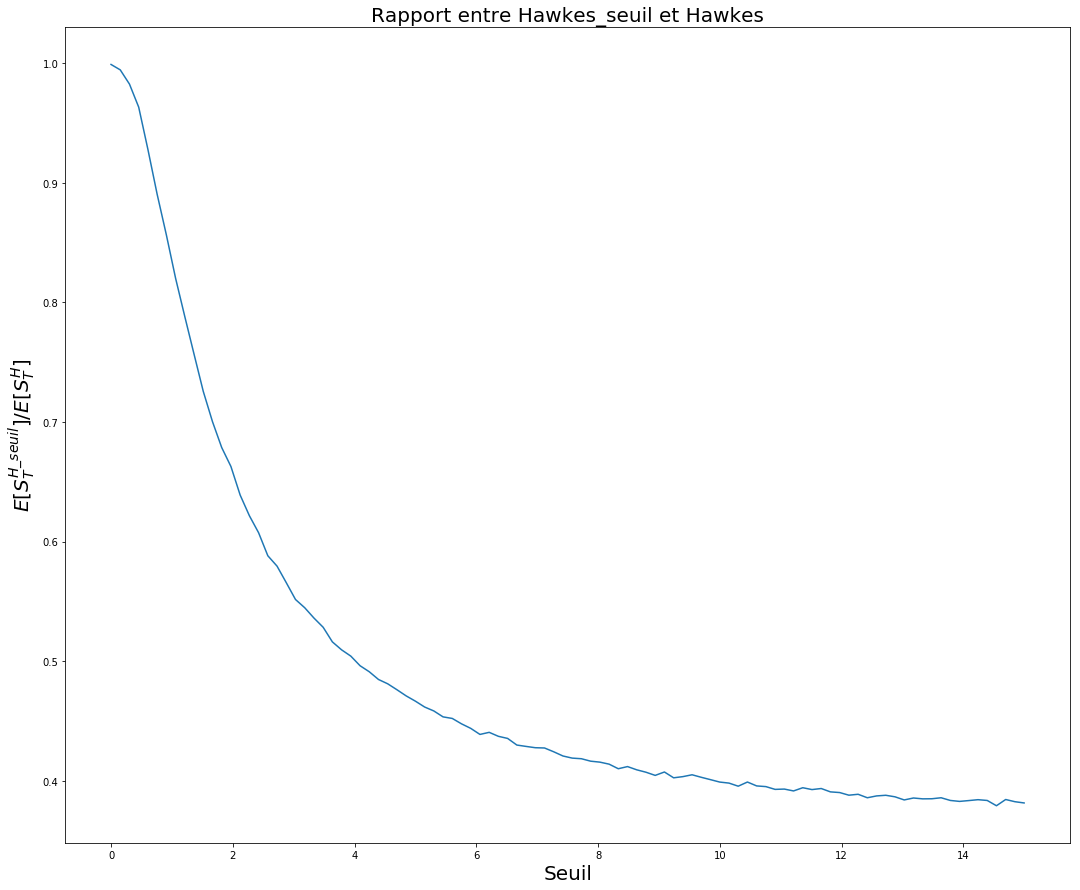

In [30]:
plot_rapport_hawkes_seuil(range_seuil, S_seuil)

In [31]:
S_seuil

array([0.99884097, 0.99431676, 0.98241387, 0.96316958, 0.92779623,
       0.89037452, 0.85637513, 0.8201518 , 0.78807649, 0.75673421,
       0.72563734, 0.70030813, 0.678676  , 0.66281719, 0.63896651,
       0.62170997, 0.60747267, 0.58824348, 0.57955636, 0.56573583,
       0.55167982, 0.54479491, 0.53618344, 0.52846319, 0.51623951,
       0.50959224, 0.50434   , 0.49632762, 0.49128349, 0.4848233 ,
       0.48120772, 0.4762535 , 0.47110832, 0.46670983, 0.4618233 ,
       0.45851882, 0.45357415, 0.45226288, 0.44775759, 0.44397459,
       0.43890959, 0.44064872, 0.43732546, 0.43556922, 0.43002758,
       0.42888615, 0.42780345, 0.4275773 , 0.42439445, 0.42088379,
       0.41911614, 0.41859847, 0.41655077, 0.41575212, 0.41407303,
       0.4102336 , 0.41203618, 0.40932635, 0.40732075, 0.40466921,
       0.40750939, 0.40264907, 0.40363331, 0.40518447, 0.40307048,
       0.40110079, 0.39909011, 0.39823028, 0.39564904, 0.39911773,
       0.39587002, 0.39529789, 0.39297681, 0.39323705, 0.39167